In [1]:
import numpy as np

In [47]:
data = ['I am happy', 'I am sad', 'I am very happy', 'I am very sad']
data = ['* ' + sentence + ' *' for sentence in data]
data

['* I am happy *', '* I am sad *', '* I am very happy *', '* I am very sad *']

In [25]:
vocabulary = set([word for sentence in data for word in sentence.split(' ')])
print(f'vocabulary: {vocabulary}')

word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocabulary: {'I', 'am', 'very', '*', 'happy', 'sad'}


In [41]:
embedding_dim = 300
embedding = np.random.rand(len(vocabulary), 2, embedding_dim)

In [ ]:
context_size = 1
learning_rate = 1e-3

for sentence in data:
    sentence = sentence.split(' ')
    sentence_length = len(sentence)

    for t, center_word in enumerate(sentence[1:-1]):
        t = t+1
        context_words_before = [sentence[t-i] for i in range(1, context_size+1) if t-i >= 0]
        context_words_after = [sentence[t+i] for i in range(1, context_size+1) if t+i <= sentence_length]
        context_words = context_words_before + context_words_after

        center_word_idx = word2idx[center_word]
        center_word_embedding = embedding[center_word_idx, 0, :]

        for context_word in context_words:
            context_word_idx = word2idx[context_word]
            context_word_embedding = embedding[context_word_idx, 1, :]
            
            res = 0
            total_prob = 0

            for word in vocabulary:
                word_embedding = embedding[word2idx[word],1,:]
                res += np.exp(np.dot(context_word_embedding, word_embedding)) * word_embedding
                total_prob += np.exp(np.dot(context_word_embedding, word_embedding))

            dLdcenter = context_word_embedding - res / total_prob
            embedding[center_word_idx, 1, :] -= learning_rate * dLdcenter
            dLdcontext = center_word_embedding
            embedding[context_word_idx, 1, :] -= learning_rate * dLdcenter

array([[[0.96799714, 0.42948181, 0.38970512, ..., 0.89831622,
         0.00290295, 0.30598807],
        [0.94035048, 0.41866055, 0.71654228, ..., 0.60068021,
         0.2026971 , 0.66046643]],

       [[0.82937081, 0.60430388, 0.2251811 , ..., 0.35670636,
         0.49727887, 0.22723934],
        [0.42022963, 0.97849019, 0.95352043, ..., 0.51935515,
         0.12965886, 0.05580098]],

       [[0.06137012, 0.58493653, 0.83118717, ..., 0.99788455,
         0.0053244 , 0.17152835],
        [0.1328322 , 0.97687069, 0.14740255, ..., 0.82247519,
         0.65690515, 0.79848608]],

       [[0.03096125, 0.34144617, 0.55209207, ..., 0.4454744 ,
         0.84293434, 0.03805454],
        [0.25034318, 0.03912687, 0.17865286, ..., 0.94728976,
         0.47652886, 0.08564847]],

       [[0.55234437, 0.29772116, 0.89966045, ..., 0.53866964,
         0.73971994, 0.29952712],
        [0.2837925 , 0.80956791, 0.2232075 , ..., 0.23414363,
         0.91605919, 0.94446949]],

       [[0.33549116, 0.3310254

In [55]:
from tqdm import tqdm

Epoch 1/3, Loss: -0.0010
Epoch 2/3, Loss: -0.0029
Epoch 3/3, Loss: -0.0049


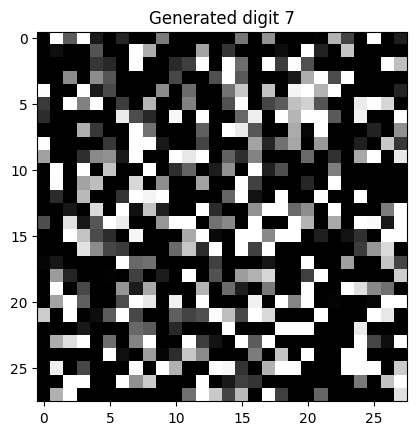

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------
# Hyperparameters
# -------------------------
x_dim = 28*28
y_dim = 10
hidden_dim = 256
batch_size = 64
lr = 1e-6
epochs = 3
steps_sampling = 200
sampling_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Prepare MNIST
# -------------------------
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -------------------------
# Define EBM network
# -------------------------
class EBMMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(x_dim + y_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)  # energy scalar
        self.relu = nn.ReLU()
    
    def forward(self, x, y):
        # x: (B, x_dim), y: (B, y_dim one-hot)
        h = torch.cat([x, y], dim=1)
        h = self.relu(self.fc1(h))
        h = self.relu(self.fc2(h))
        energy = self.fc_out(h)
        return energy  # lower energy = more likely

# -------------------------
# Initialize
# -------------------------
model = EBMMnist().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# -------------------------
# Training (Contrastive / simple)
# -------------------------
for epoch in range(epochs):
    total_loss = 0
    for imgs, labels in train_loader:
        imgs = imgs.view(-1, x_dim).to(device)
        labels_oh = nn.functional.one_hot(labels, num_classes=y_dim).float().to(device)

        # Positive pairs: real (x, y)
        energy_pos = model(imgs, labels_oh)

        # Negative pairs: shuffle y
        labels_neg = labels[torch.randperm(labels.size(0))]
        labels_neg_oh = nn.functional.one_hot(labels_neg, num_classes=y_dim).float().to(device)
        energy_neg = model(imgs, labels_neg_oh)

        # Loss: push positive energies lower than negative energies
        loss = torch.mean(energy_pos) - torch.mean(energy_neg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# -------------------------
# Forward: predict y given x
# -------------------------
def predict_y(x):
    x = x.view(1, -1).to(device)
    energies = []
    for c in range(y_dim):
        y_oh = torch.zeros(1, y_dim, device=device)
        y_oh[0, c] = 1.0
        energies.append(model(x, y_oh).item())
    # Lowest energy = predicted class
    return energies.index(min(energies))

# -------------------------
# Backward: generate x given y
# -------------------------
def sample_x_given_y(target_class):
    y = torch.zeros(1, y_dim, device=device)
    y[0, target_class] = 1.0
    x = torch.randn(1, x_dim, device=device, requires_grad=True)

    optimizer_x = optim.SGD([x], lr=sampling_lr)
    for step in range(steps_sampling):
        optimizer_x.zero_grad()
        energy = model(x, y)
        energy.backward()
        optimizer_x.step()
        x.data.clamp_(0, 1)  # keep pixel range valid

    return x.detach().cpu().view(28,28)

# -------------------------
# Example: generate digit 7
# -------------------------
digit = 7
x_sample = sample_x_given_y(digit)
plt.imshow(x_sample, cmap='gray')
plt.title(f"Generated digit {digit}")
plt.show()

memory.shape

In [52]:
np.sqrt(794)

np.float64(28.178005607210743)